In [1]:
from collections import namedtuple
import glob
from itertools import islice
from operator import lt, gt

from astropy.coordinates import Angle, SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
import numpy as np
import pandas as pd
from scipy import interpolate

In [2]:
# Read in the source selection catalog
whsp = pd.read_csv("2WHSP_catalog.txt", skiprows=4, delimiter=' *\| *', engine='python', na_filter=False)
# Drop dummy columns caused by extra delimiters
whsp.drop(whsp.columns[[0, -1]], axis=1, inplace=True)
# Munge flags into Boolean values
for col in whsp.columns:
    if col.endswith('_flag'):
        whsp[col].replace({':': True, '': False}, inplace=True)
    elif col.endswith('_limit'):
        whsp[col].replace({'&gt;': True, '': False}, inplace=True)
# Convert sexagesimal coordinates to decimal degrees
whsp['ra'] = Angle(whsp['ra'], unit='hourangle').to_value(u.degree)
whsp['dec'] = Angle(whsp['dec'], unit='deg').value
whsp

,name,ra,dec,lii,bii,source_flag,bzcat_object_type,log_nu_peak_limit,log_nu_peak,log_nu_peak_flag,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,2WHSP J045823.5-864408,74.597917,-86.735556,299.6559,-28.6358,False,,False,16.0,True,...,True,False,,False,,,,,,0.10
1,2WHSP J211011.1-861847,317.546250,-86.313056,306.4041,-29.1836,False,,False,15.4,False,...,False,False,,False,,3FGL J2108.6-8619,1.74,0.26,2FHL J2112.5-861,0.20
2,2WHSP J153103.7-861225,232.765417,-86.206944,305.5986,-24.1936,False,,False,15.6,False,...,False,False,,False,,,,,,0.32
3,2WHSP J102634.3-854314,156.642917,-85.720556,300.1731,-23.6490,False,5BZB,False,15.0,False,...,False,False,,False,,3FGL J1026.4-8542,2.01,0.08,2FHL J1026.9-854,0.63
4,2WHSP J222610.9-840621,336.545417,-84.105833,307.0361,-31.8176,False,,False,16.1,False,...,False,False,,False,,,,,,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,2WHSP J041949.3+843835,64.955417,84.643056,127.5486,23.7625,False,,False,16.2,False,...,False,False,,False,,,,,,0.10
1687,2WHSP J214609.6+850148,326.540000,85.030000,119.0102,23.6419,False,,False,15.7,False,...,False,False,,False,,,,,,0.25
1688,2WHSP J074716.2+851207,116.817500,85.201944,128.2161,28.1864,False,,False,16.8,False,...,False,False,,False,,3FGL J0746.9+8511,1.79,0.12,,0.25
1689,2WHSP J104810.9+855957,162.045417,85.999167,125.3103,30.5442,False,,False,17.0,True,...,True,False,,False,,,,,,0.16


In [3]:
# Define sky selection cuts
def sky_selection_cuts(ra, dec, ra_bounds=None, dec_bounds=None, b_bounds=None):
    """Applies selection cuts on sky coordinates
    
    RA, Dec, and bounds should be specified in degrees.
    Bounds should be expressed as lists of bounds tuples:
        [(lower_bound_1, upper_bound_1), (lower_bound_2, upper_bound_2)...]
    """
    cut_mask = np.ones(len(ra), dtype=bool)
    print("{} sources total".format(len(cut_mask)))
    if ra_bounds:
        ra_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in ra_bounds:
            ra_mask |= (lower <= ra[cut_mask]) & (ra[cut_mask] <= upper)
        cut_mask[cut_mask] &= ra_mask
        print("{} sources left after RA cut".format(sum(cut_mask)))
    if dec_bounds:
        dec_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in dec_bounds:
            dec_mask |= (lower <= dec[cut_mask]) & (dec[cut_mask] <= upper)
        cut_mask[cut_mask] &= dec_mask
        print("{} sources left after declination cut".format(sum(cut_mask)))
    if b_bounds:
        b = SkyCoord(ra=ra[cut_mask], dec=dec[cut_mask], unit='deg').galactic.b.value
        b_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in b_bounds:
            b_mask |= (lower < b) & (b < upper)
        cut_mask[cut_mask] &= b_mask
        print("{} sources left after Galactic latitude cut".format(sum(cut_mask)))
    return cut_mask

In [4]:
# Apply selection cuts to 2WHSP catalog
#ra_bounds = [((6*u.hourangle).to_value(u.degree), (10*u.hourangle).to_value(u.degree))]
ra_bounds = [((0*u.hourangle).to_value(u.degree), (24*u.hourangle).to_value(u.degree))]
dec_bounds = [(1.7, 61.7)]
b_bounds = [(-np.inf, -10), (10, np.inf)]

cut_mask = sky_selection_cuts(whsp.ra, whsp.dec, ra_bounds=ra_bounds, dec_bounds=dec_bounds, b_bounds=b_bounds)
cut_mask[cut_mask] = whsp.figure_of_merit[cut_mask] > 1
print("{} sources left after Figure of Merit cut".format(sum(cut_mask)))

1691 sources total
1691 sources left after RA cut
787 sources left after declination cut
776 sources left after Galactic latitude cut
40 sources left after Figure of Merit cut


In [5]:
# Calculate sky coverage (taking into account sky selection cuts only)
# The effects of the RA and Dec cuts are determined analytically,
# but the effect of the Galactic latitude cut is found using a Monte Carlo method,
# since that coordinate is not orthogonal to the first two

num_points = 1000000
coords = np.random.random([num_points, 2])

ra_lo, ra_hi = ra_bounds[0]
ra_fraction = (ra_hi - ra_lo) / 360
print("Fraction kept after RA cut: {:.04}".format(ra_fraction))
ra = (ra_hi - ra_lo)*coords[:,0] + ra_lo

dec_lo, dec_hi = (np.pi/180)*np.array(dec_bounds[0])
dec_fraction = (np.sin(dec_hi) - np.sin(dec_lo)) / 2
print("Fraction kept after Dec cut: {:.04}".format(dec_fraction))
dec = 180/np.pi*np.arcsin(2*np.sin((dec_hi - dec_lo)/2)*np.cos((dec_hi + dec_lo)/2)*coords[:,1] + np.sin(dec_lo))

b_fraction = sum(sky_selection_cuts(ra, dec, b_bounds=b_bounds)) / num_points
print("Fraction kept after Galactic latitude cut: {:.04}".format(b_fraction))

sky_coverage = ra_fraction * dec_fraction * b_fraction
print("Sky coverage: {:.04}".format(sky_coverage))

Fraction kept after RA cut: 1.0
Fraction kept after Dec cut: 0.4254
1000000 sources total
821082 sources left after Galactic latitude cut
Fraction kept after Galactic latitude cut: 0.8211
Sky coverage: 0.3493


In [6]:
# Since we required 2WHSP FoM > 1 (as opposed to >= 1),
# determine the synchrotron flux limit using the flux of the weakest possibly detected source
# Don't take into account the other cuts, since the cuts are independent

min_log_nu_f_nu = np.min(whsp.log_nu_f_nu[whsp.figure_of_merit > 1].to_numpy())
min_nu_f_nu = (10**min_log_nu_f_nu)*u.erg/(u.cm*u.cm)/u.s
print("Minimum log(nu F_nu) is {}, giving {:.04}".format(min_log_nu_f_nu, min_nu_f_nu))

Minimum log(nu F_nu) is -12.2, giving 6.31e-13 erg / (cm2 s)


In [7]:
def logN_logS(fluxes, sky_coverage=1.0, label=None):
    nums = np.array(range(len(fluxes), 0, -1)) / sky_coverage / (4*np.pi*u.sr).to_value(u.degree*u.degree)
    plt.plot(np.sort(fluxes), nums, label=label)
    plt.xscale('log')
    plt.xlabel("S [erg cm^-2 s^-1]")
    plt.yscale('log')
    plt.ylabel("N(>S) [deg^-2]")
    plt.legend()

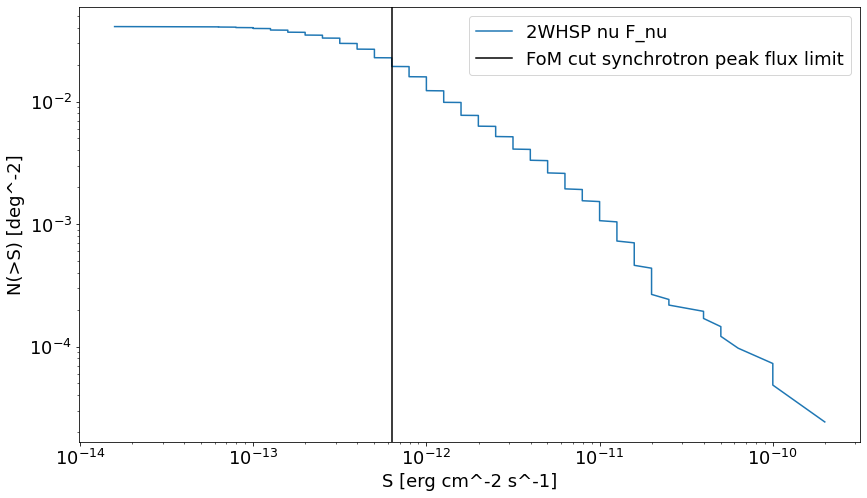

In [8]:
# Plot the logN-logS of the 2WHSP sources, to show that the slope is constant in the selection region
logN_logS(10**whsp.log_nu_f_nu, label="2WHSP nu F_nu")
plt.axvline(min_nu_f_nu.value, color='k', label="FoM cut synchrotron peak flux limit")
plt.legend()

In [9]:
# Read in our data and join in to the selected 2WHSP sources
vts_data = pd.read_csv("LF_blazar_data.csv")
data = vts_data.join(whsp[cut_mask].set_index('name'), on='whsp_name', how='inner')

# Olivier calculated an average Mrk 501 flux of 23% Crab (it's listed as "variable" in TeVCat)
data.loc[data.source == "Mkn 501", 'tevcat_flux_crab'] = 0.23

data

,source,whsp_name,z,archival_hours,year1_hours,tevcat_flux_crab,tevcat_index,ra,dec,lii,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,RGB J0152+017,2WHSP J015239.5+014717,0.080,19.3,0.0,0.020,2.95,28.164583,1.788056,152.3768,...,False,False,0.080,False,,3FGL J0152.6+0148,1.89,0.10,2FHL J0152.8+014,1.26
1,B3 0133+388,2WHSP J013632.5+390558,NaN,18.5,0.0,NaN,NaN,24.135417,39.099444,132.4162,...,False,False,,False,,3FGL J0136.5+3905,1.70,0.02,2FHL J0136.5+390,2.51
2,1ES 0120+340,2WHSP J012308.5+342048,0.270,11.1,5.0,NaN,NaN,20.785417,34.346667,130.3452,...,False,False,0.270,False,,3FGL J0122.8+3423,1.48,0.14,,3.16
3,RGB J0045+214,2WHSP J004519.2+212739,NaN,0.9,3.5,NaN,NaN,11.330000,21.460833,121.0345,...,False,False,,False,,3FGL J0045.3+2126,1.90,0.05,2FHL J0045.2+212,1.26
4,1ES 0229+200,2WHSP J023248.5+201717,0.139,198.6,18.0,0.018,2.50,38.202083,20.288056,152.9407,...,False,False,0.139,False,,3FGL J0232.8+2016,2.03,0.14,,2.00
5,RGB J0321+236,2WHSP J032159.8+233611,NaN,10.6,4.0,NaN,NaN,50.499167,23.603056,162.0879,...,False,False,,False,,3FGL J0322.0+2335,1.95,0.07,2FHL J0322.0+233,1.26
6,1FGL J0333.7+2919,2WHSP J033349.0+291631,NaN,3.3,7.9,NaN,NaN,53.454167,29.275278,160.5247,...,False,False,,False,,3FGL J0333.6+2916,1.86,0.06,2FHL J0333.7+291,1.26
7,RGB J0316+090,2WHSP J031612.7+090442,NaN,5.7,6.0,NaN,NaN,49.052917,9.078333,172.1051,...,False,False,,False,,3FGL J0316.1+0904,1.92,0.04,2FHL J0316.1+090,2.00
8,GB6 J0540+5823,2WHSP J054029.9+582338,NaN,2.8,8.7,NaN,NaN,85.124583,58.393889,153.9316,...,False,False,,False,,3FGL J0540.4+5823,2.00,0.08,2FHL J0540.5+582,1.58
9,RGB J0710+591,2WHSP J071029.9+590820,0.120,166.2,0.0,0.030,2.69,107.624583,59.138889,157.4043,...,False,False,0.120,False,,3FGL J0710.3+5908,1.66,0.09,2FHL J0710.5+590,3.98


In [10]:
# RGB J2243+203 should have been included in our LF selection (FOM = 1.58)
# 1ES 2344+514 should have been excluded from our LF selection (galactic latitude = -9.9)

print("Should have included: {}".format(",".join(list(set(whsp.name[cut_mask]) - set(vts_data.whsp_name)))))
print("Should have excluded: {}".format(",".join(list(set(vts_data.whsp_name) - set(whsp.name[cut_mask])))))

Should have included: 2WHSP J224354.7+202102
Should have excluded: 2WHSP J234704.7+514216


In [11]:
def deabsorb_spectrum(spectrum, bin_edges, z):
    """Apply EBL deabsorption to the fluxes.
    
    Applies EBL deabsorption to the fluxes using the Dominguez (2011) model, assuming a power law source spectrum.
    
    spectrum: Quantity [numpy array of any unit convertible to cm^-2 s^-1]
    bin_edges: Quantity
    z: array
        
    Assumes z is within the range: [0.01, 2].
    Assumes the spectrum is within the range: [30 GeV, 30 TeV],
    otherwise no deabsorption is applied.
    
    Returns the EBL-deabsorbed spectrum.
    """
    # Load the Dominguez (2011) model
    model_path = "tau_dominguez11.txt"
    # Extract the string representation of the list of redshifts, and convert to a numpy array
    with open(model_path) as model_file:
        line = list(islice(model_file, 1, 2))[0]
        zlist = line.partition("# Distance: z(source) = ")[2].strip()
        model_zs = np.array([float(z) for z in zlist.strip('[]').split(',')])
    model = np.genfromtxt(model_path)
    model_energies = model[:,0]  # TeV
    model_taus = model[:,1:]
        
    # Deabsorb the fluxes
    bin_ctrs = np.sqrt(bin_edges[:,:-1] * bin_edges[:,1:]).to_value(u.TeV)
    model_points = np.vstack(list(map(np.ravel, np.meshgrid(model_zs, model_energies)))).T
    interp_fn = interpolate.LinearNDInterpolator(model_points, model_taus.flatten(), fill_value=0, rescale=True)
    if not np.isscalar(z):
        z = np.expand_dims(z, axis=1)
    bin_zs = np.broadcast_to(z, bin_ctrs.shape)
    data_points = np.vstack(list(map(np.ravel, [bin_zs, bin_ctrs]))).T
    taus = interp_fn(data_points)
    deabs_spectrum = spectrum * np.exp(taus.reshape(spectrum.shape))
        
    return deabs_spectrum

In [12]:
def crab_flux_to_photon_flux(crab_flux, threshold_energy):
    crab_index= 2.49
    crab_norm = 3.2e-11/(u.cm*u.cm)/u.s/u.TeV
    crab_E0 = 1.0 * u.TeV
    crab_photon_flux = (crab_norm * crab_E0 / (crab_index - 1)
                        * np.power(threshold_energy.to(u.TeV)/crab_E0, 1 - crab_index))
    return crab_flux * crab_photon_flux

def get_spectrum(flux, index, e_min, e_max, num_bins=60, e_0=1.*u.TeV, e_start=0.03*u.TeV, e_stop=30.*u.TeV):
    """Return the binned fluxes corresponding to the power law spectrum, given the spectral parameters
    
    Arguments:
        flux: Quantity, total flux of the source
        index: array, photon spectral index
        e_min: Quantity [energy], energy threshold of the spectrum
        e_max: Quantity [energy], maximum energy of the spectrum
        e_0: Quantity [energy], scale energy of the spectrum
        e_start: Quantity [energy], smallest energy to return
        e_stop: Quantity [energy], largest energy to return
        num_bins: int, number of flux bins to include in the spectrum
    
    Returns:
        spectrum: Quantity [flux.unit], binned fluxes from e_start to e_stop
        bin_edges: Quantity [TeV], sequence of length num_bins + 1 defining the bin energies
    """
    
    # Approxmate the spectrum as a sequence of energy bins
    # determined by the provided spectral parameters and integrated flux
    norm = flux * (index - 1) / e_0 / ((e_min/e_0)**(1 - index) - (e_max/e_0)**(1 - index))
    norm = np.expand_dims(norm, axis=1)
    bin_edges = np.tile(np.geomspace(e_start.to_value(u.TeV), e_stop.to_value(u.TeV), num=(num_bins + 1)),
                        flux.shape + (1,))*u.TeV
    # The bin geometric center (ignoring the spectral index) is a good approximation for the bin average energy
    # in the limit of many small logarithmically spaced bins
    bin_ctrs = np.sqrt(bin_edges[:,:-1] * bin_edges[:,1:])
    bin_widths = bin_edges[:,1:] - bin_edges[:,:-1]
    spectrum = (norm.to(1/(u.cm*u.cm)/u.s/u.TeV) * bin_widths
                * np.power(bin_ctrs/e_0, -np.expand_dims(index, axis=1)))
    
    def beyond_bound(energy, op):
        return op(bin_ctrs.to_value(u.TeV), np.reshape(energy.to_value(u.TeV), (-1, 1)))
    
    spectrum[beyond_bound(e_min, lt) | beyond_bound(e_max, gt)] = 0

    return spectrum.to(flux.unit), bin_edges


def spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=False):
    deabs_spectrum = deabsorb_spectrum(spectrum, bin_edges, z) if deabsorb else spectrum
    bin_ctrs = np.sqrt(bin_edges[:,:-1] * bin_edges[:,1:])
    eflux = np.sum(deabs_spectrum * bin_ctrs, axis=1)
    return eflux


cosmo = FlatLambdaCDM(H0=70*(u.km/u.s/u.Mpc), Tcmb0=2.725*u.K, Om0=0.3)

def luminosity_to_eflux(luminosity, index, z):
    """Convert the luminosity to energy flux
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    eflux = luminosity / (4*np.pi * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1))
    return eflux.to(u.erg/(u.cm*u.cm)/u.s)


def eflux_to_luminosity(eflux, index, z):
    """Convert the energy flux to luminosity
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    luminosity = 4*np.pi * eflux * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1)
    return luminosity.to(u.erg/u.s)


def spectrum_to_luminosity(spectrum, bin_edges, index, z, deabsorb=False):
    eflux = spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=deabsorb)
    luminosity = eflux_to_luminosity(eflux, index, z)
    return luminosity

39 sources pass cuts


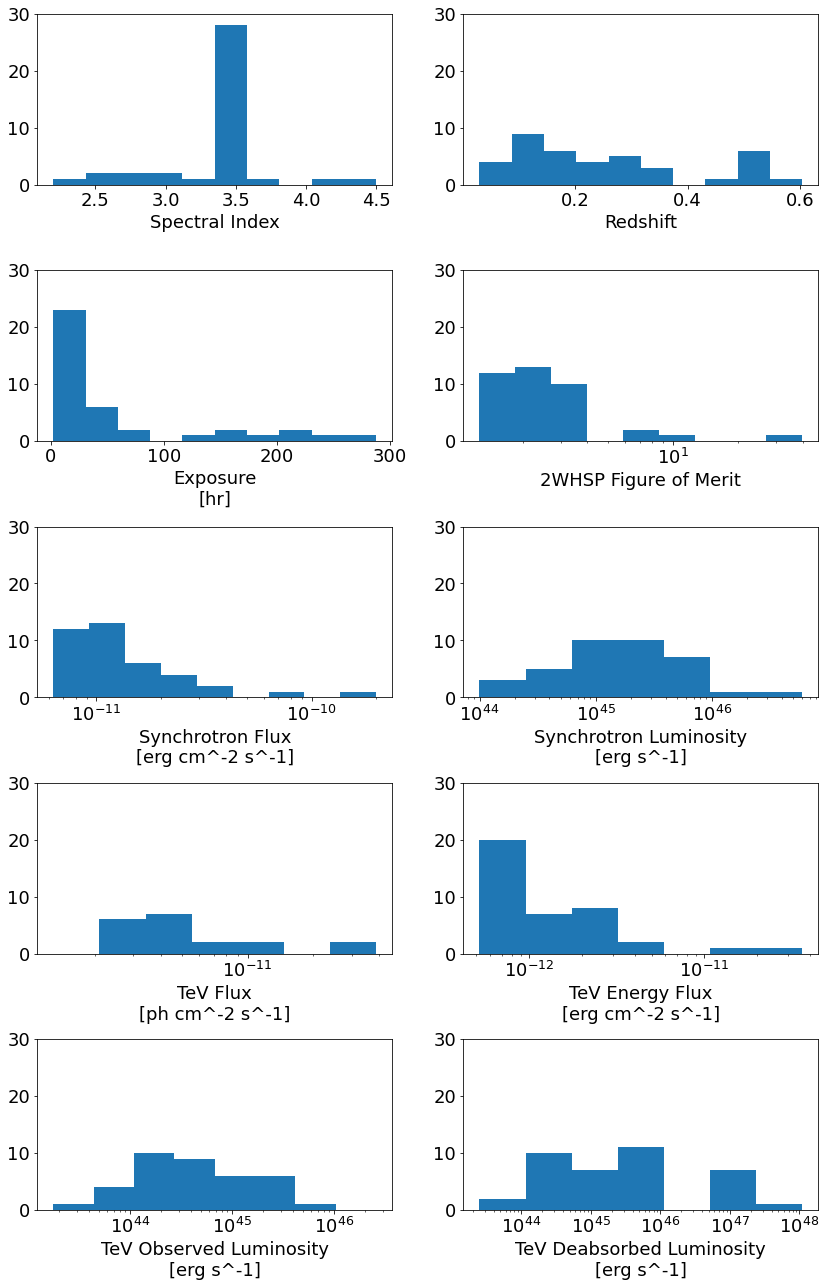

In [13]:
Dist = namedtuple('Dist', ['arr', 'label'])
dists = {}

# Use a default spectral index for sources without one in TeVCat
dists['index'] = Dist(np.nan_to_num(data.tevcat_index.to_numpy(), nan=3.5)*u.dimensionless_unscaled,
                      "Spectral Index")
# Use a default redshift for sources without a known redshift
dists['z'] = Dist(np.nan_to_num(data.z.to_numpy(), nan=0.5)*u.dimensionless_unscaled, "Redshift")
dists['exposure'] = Dist((data.archival_hours + data.year1_hours).to_numpy()*u.hr, "Exposure\n[hr]")
dists['fom'] = Dist(data.figure_of_merit.to_numpy()*u.dimensionless_unscaled, "2WHSP Figure of Merit")

dists['whsp_flux'] = Dist(10**data.log_nu_f_nu.to_numpy()*u.erg/(u.cm*u.cm)/u.s,
                          "Synchrotron Flux\n[erg cm^-2 s^-1]")
synchrotron_peak_index = 1  # The SED is flat at the peak -> spectral index = 1
dists['whsp_luminosity'] = Dist(eflux_to_luminosity(dists['whsp_flux'].arr, synchrotron_peak_index,
                                                          dists['z'].arr),
                                "Synchrotron Luminosity\n[erg s^-1]")

# Since we're using fluxes from TeVCat, we don't have the actual spectra
# Estimate e_max using as inversely scaled with redshift
e_min = 0.3*u.TeV
e_max = u.TeV/(3 * dists['z'].arr)
e_start = 0.03*u.TeV
e_stop = 30.*u.TeV
num_bins = 60  # Number of spectral bins (20 per decade)

# Use a default flux in Crab units for sources without one in TeVCat
dists['tev_flux'] = Dist(crab_flux_to_photon_flux(np.nan_to_num(data.tevcat_flux_crab.to_numpy(),
                                                                nan=0.01)*u.dimensionless_unscaled,
                                                  e_min),
                         "TeV Flux\n[ph cm^-2 s^-1]")
spectrum, bin_edges = get_spectrum(dists['tev_flux'].arr, dists['index'].arr, e_min=e_min, e_max=e_max,
                                   e_start=e_start, e_stop=e_stop, num_bins=num_bins)
dists['tev_eflux'] = Dist(spectrum_to_eflux(spectrum, bin_edges, dists['z'].arr, deabsorb=False),
                          "TeV Energy Flux\n[erg cm^-2 s^-1]")
dists['tev_obs_luminosity'] = Dist(spectrum_to_luminosity(spectrum, bin_edges, dists['index'].arr, dists['z'].arr,
                                                          deabsorb=False),
                                   "TeV Observed Luminosity\n[erg s^-1]")
dists['tev_deabs_luminosity'] = Dist(spectrum_to_luminosity(spectrum, bin_edges, dists['index'].arr,
                                                            dists['z'].arr, deabsorb=True),
                                     "TeV Deabsorbed Luminosity\n[erg s^-1]")

# Include only sources with TeV fluxes and known redshifts (as well as the other values)
mask = np.ones(len(dists['tev_flux'].arr), dtype=bool)
for key, dist in dists.items():
    mask &= ~np.isnan(dist.arr)
for key, dist in dists.items():
    dists[key] = Dist(dist.arr[mask], dist.label)
e_max = e_max[mask]
print("{} sources pass cuts".format(sum(mask)))

# Plot distributions of the data
fig, axes = plt.subplots(5, 2, figsize=(14.0, 22.0))
for ax, (key, dist) in zip(axes.ravel(), dists.items()):
    if key in ['index', 'z', 'exposure']:
        bins = 10
    else:
        _, bins = np.histogram(np.log10(dist.arr.value), bins='auto')
        bins = 10**bins
        ax.set_xscale('log')
    ax.hist(dist.arr.value, bins=bins)
    ax.set_ylim(0, 30)
    ax.set_xlabel(dist.label)
plt.subplots_adjust(hspace=0.5)

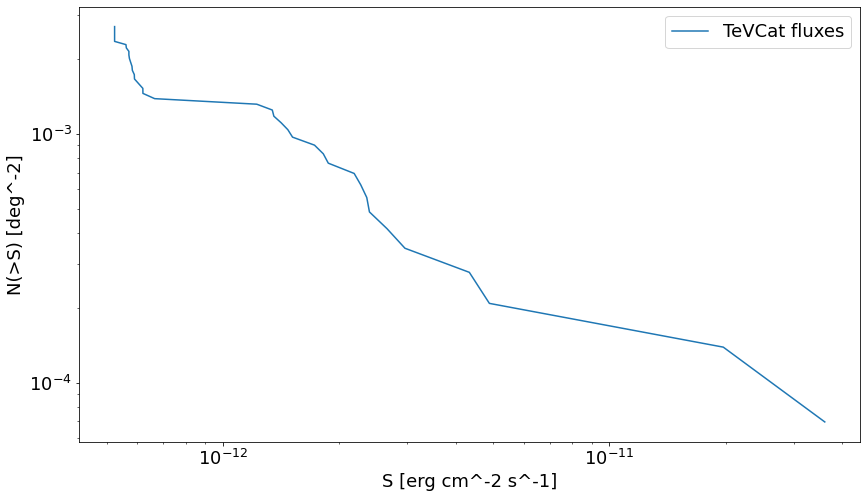

In [14]:
# Plot the logN-logS of the VERITAS sources (using the TeVCat fluxes)
logN_logS(dists['tev_eflux'].arr, sky_coverage=sky_coverage, label="TeVCat fluxes")

In [15]:
def vts_sensitivity_spectrum(exposure, index, e_min, e_max, num_bins):
    """Returns the spectrum equivalent to the VERITAS sensitivity at the given exposure
    
    Assumes that VERITAS has the same sensitivity regardless of spectral index,
    as I don't have any better VERITAS sensitivity information. A Crab spectrum is assumed here.
    
    The VERITAS sensitivity data were pulled from the VERITAS website at
    https://veritas.sao.arizona.edu/about-veritas-mainmenu-81/veritas-specifications-mainmenu-111
    and sampled using the WebPlotDigitizer tool at https://automeris.io/WebPlotDigitizer/.
    """
    # Load VERITAS sensitivity points
    # Flux [Crab] | Observation Time [h]
    points = pd.read_csv('veritas_sensitivity.csv')
    sensitivity_flux = crab_flux_to_photon_flux(points.flux.to_numpy(), e_min)
    sensitivity_exposure = points.exposure.to_numpy()*u.hr
    flux = np.zeros(len(exposure))
    for i in range(len(flux)):
        flux[i] = np.interp(exposure[i].to_value(u.hr), sensitivity_exposure.to_value(u.hr),
                            sensitivity_flux.value)
    flux *= sensitivity_flux.unit
    return get_spectrum(flux, index, e_min, e_max, num_bins=num_bins)

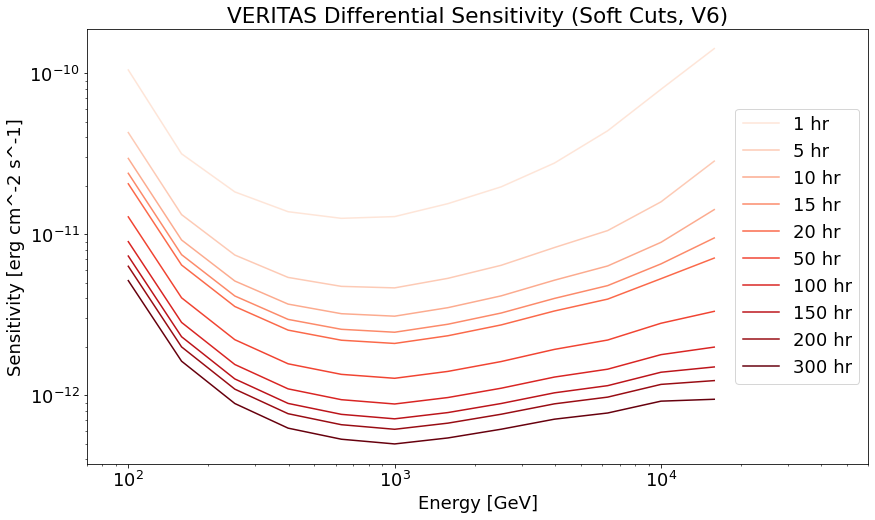

In [16]:
# Display VERITAS differential sensitivity curves

# VERITAS differential sensitivity files calculated by Deivid Ribeiro, using the script and dataset of Nahee Park.
# For a description of the sensitivity calculation, see the following presentation (Ribeiro):
# http://veritash.sao.arizona.edu:8081/AnalysisAndCalibration/190628_150612/S2019VCM_sensitivity.pdf
# and VERITAS performance paper (Park):
# https://arxiv.org/abs/1508.07070
    
# The sensitivity curves assume standard (not BDT or ITM) soft cuts, and apply to the V6 epoch from 2012-2015.


names = ['time', 'sigma^2', 'off_rate', 'on_rate', 'alpha', 'percent_Crab',
         'energy', 'logE', 'dNdE', 'sens', 'senslow', 'senshigh']

files = glob.glob('veritas_sensitivity/sensitivity_*hrs.txt')
files.sort(key=lambda f: pd.read_csv(f, names=names).time[0])

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0.1, 1, len(files)))))

for f in files:
    df = pd.read_csv(f, names=names)
    plt.plot(df.energy, df.sens, label="{} hr".format(df.time[0]))
plt.title("VERITAS Differential Sensitivity (Soft Cuts, V6)")
plt.xscale('log')
plt.yscale('log')
plt.xlim((70, 6e4))
plt.xlabel("Energy [GeV]")
plt.ylabel("Sensitivity [erg cm^-2 s^-1]")
plt.legend(loc="center right")

In [17]:
def limiting_eflux_to_redshift(eflux, luminosity, index):
    num_zs = 250
    zs = np.linspace(0.0, 0.02*num_zs, num_zs)
    efluxes = np.zeros((len(luminosity), num_zs)) * eflux.unit
    for i, z in enumerate(zs):
        efluxes[:, i] = luminosity_to_eflux(luminosity, index, z)
    differences = np.abs(efluxes - np.expand_dims(eflux, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled


def limiting_spectrum_to_redshift(spectrum, bin_edges, luminosity, index):
    num_zs = 125
    zs = np.linspace(0.0, 0.01*num_zs, num_zs)
    luminosities = np.zeros((len(luminosity), num_zs)) * luminosity.unit
    for i, z in enumerate(zs):
        luminosities[:, i] = spectrum_to_luminosity(spectrum, bin_edges, index, z,
                                                    deabsorb=True).to(luminosity.unit)
    differences = np.abs(luminosities - np.expand_dims(luminosity, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled

/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-11-8eedbae5d677>:36: RuntimeWarning: overflow encountered in exp
  deabs_spectrum = spectrum * np.exp(taus.reshape(spectrum.shape))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


z: [0.08  0.5   0.27  0.5   0.139 0.5   0.5   0.5   0.5   0.12  0.203 0.137
 0.198 0.19  0.278 0.35  0.03  0.2   0.3   0.138 0.143 0.33  0.18  0.13
 0.218 0.135 0.31  0.604 0.443 0.129 0.16  0.24  0.344 0.235 0.03  0.055
 0.18  0.3   0.119]
limiting_tev_z: [0.09072581 0.49395161 0.26209677 0.44354839 0.2016129  0.48387097
 0.47379032 0.47379032 0.47379032 0.19153226 0.26209677 0.17137097
 0.23185484 0.19153226 0.24193548 0.32258065 0.1108871  0.28225806
 0.30241935 0.13104839 0.13104839 0.32258065 0.3125     0.18145161
 0.27217742 0.2016129  0.30241935 0.64516129 0.57459677 0.2016129
 0.18145161 0.24193548 0.30241935 0.19153226 0.1108871  0.07056452
 0.2016129  0.23185484 0.16129032]
limiting_whsp_z: [0.24096386 1.68674699 1.04417671 1.28514056 0.46184739 1.28514056
 1.28514056 1.54618474 1.40562249 0.54216867 0.80321285 0.562249
 0.54216867 0.68273092 0.88353414 1.10441767 0.42168675 0.86345382
 1.04417671 0.46184739 0.52208835 0.9437751  0.72289157 0.48192771
 0.58232932 0.60240964 1

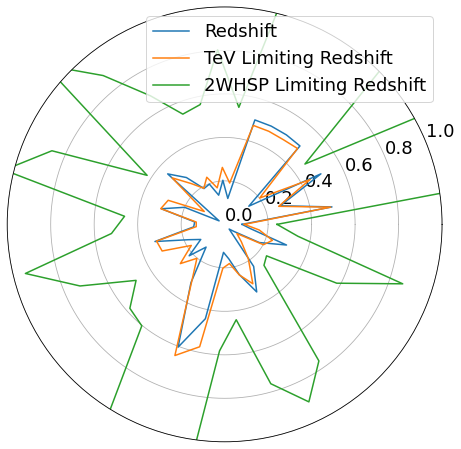

In [18]:
# Compare the limiting redshifts from the actual VERITAS observations
# to those from the selection flux limit

limiting_whsp_fluxes = np.ones(dists['whsp_luminosity'].arr.size) * min_nu_f_nu
dists['limiting_whsp_z'] = Dist(limiting_eflux_to_redshift(limiting_whsp_fluxes, dists['whsp_luminosity'].arr,
                                                                 synchrotron_peak_index),
                                "2WHSP Limiting Redshift")
limiting_vts_spectra, limiting_vts_bin_edges = vts_sensitivity_spectrum(dists['exposure'].arr, dists['index'].arr,
                                                                        e_min=e_min, e_max=e_max,
                                                                        num_bins=num_bins)
dists['limiting_tev_z'] = Dist(limiting_spectrum_to_redshift(limiting_vts_spectra, limiting_vts_bin_edges,
                                                             dists['tev_deabs_luminosity'].arr,
                                                             dists['index'].arr),
                               "TeV Limiting Redshift")

ax = plt.subplot(111, polar=True)
for key in ['z', 'limiting_tev_z', 'limiting_whsp_z']:
    arr = dists[key].arr
    print("{}: {}".format(key, arr))
    polar_x = (2*np.pi / arr.size)*np.arange(arr.size + 1)
    ax.plot(polar_x, np.append(arr, arr[0]), label=dists[key].label)
ax.set_xticks([])
ax.set_yticks(np.arange(0, 1.1, step=0.2))
ax.set_ylim((0, 1.0))
ax.legend()

23/39 sources detected
<V/V_max> = 0.508 +- 0.046


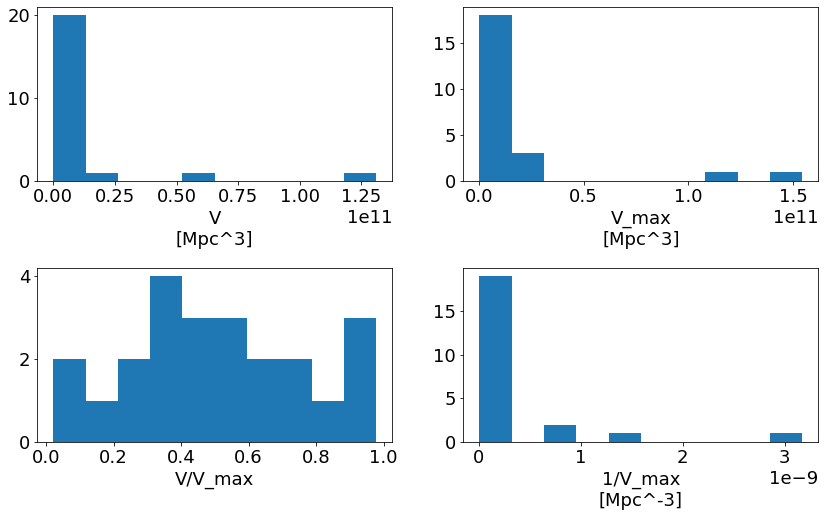

In [19]:
# Calculate V and V_max for each detected source
min_z = np.minimum(dists['limiting_whsp_z'].arr, dists['limiting_tev_z'].arr)
detected = dists['z'].arr < min_z
print("{}/{} sources detected".format(sum(detected), sum(mask)))

dists['V'] = Dist(cosmo.comoving_volume(dists['z'].arr.value[detected]) / sky_coverage, "V\n[Mpc^3]")
dists['V_max'] = Dist(cosmo.comoving_volume(min_z.value[detected]) / sky_coverage, "V_max\n[Mpc^3]")
dists['1/V_max'] = Dist(1 / dists['V_max'].arr, "1/V_max\n[Mpc^-3]")
dists['1/V_max_var'] = Dist(1 / dists['V_max'].arr**2, "Variance of 1/V_max\n[Mpc^-6]")
dists['V/V_max'] = Dist(dists['V'].arr / dists['V_max'].arr, "V/V_max")

print("<V/V_max> = {:.3f} +- {:.3f}".format(np.mean(dists['V/V_max'].arr), np.sqrt(1/(12*sum(mask)))))

fig, axes = plt.subplots(2, 2)
for ax, key in zip(axes.ravel(), ['V', 'V_max', 'V/V_max', '1/V_max']):
    ax.hist(dists[key].arr.value)
    ax.set_xlabel(dists[key].label)
plt.subplots_adjust(hspace=0.5)

In [20]:
# Calculate the luminosity function using 1/V_max method of Schmidt (1968)

def luminosity_function(luminosities, densities, density_variances, energy_threshold=e_min, label=None):
    sort_idxs = luminosities.argsort()
    sorted_luminosities = luminosities[sort_idxs[::-1]]
    cum_densities = np.cumsum(densities[sort_idxs[::-1]])
    cum_density_errs = np.sqrt(np.cumsum(density_variances[sort_idxs[::-1]]))
    plt.plot(sorted_luminosities, cum_densities, label=label)
    plt.fill_between(sorted_luminosities, cum_densities - cum_density_errs, cum_densities + cum_density_errs,
                     alpha=0.5)
    plt.xscale('log')
    plt.xlabel("Isotropic Luminosity (>{} TeV) [erg s^-1]".format(energy_threshold.to_value(u.TeV)))
    plt.yscale('log')
    plt.ylabel("Cumulative Space Density [Mpc^-3]")
    plt.legend()

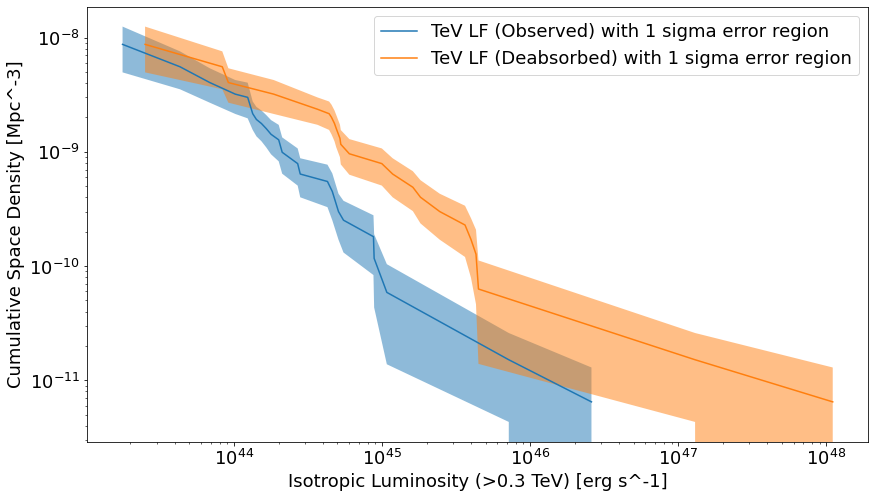

In [21]:
# Plot both the LF based on the observed luminosities (good for comparison to the EGRB)
# and based on the deabsorbed luminosities, which are the luminosities at the source
# (good for comparison to neutrino emission and calculating pair cascades)

luminosity_function(dists['tev_obs_luminosity'].arr[detected], dists['1/V_max'].arr, dists['1/V_max_var'].arr,
                    label="TeV LF (Observed) with 1 sigma error region")

luminosity_function(dists['tev_deabs_luminosity'].arr[detected], dists['1/V_max'].arr, dists['1/V_max_var'].arr,
                    label="TeV LF (Deabsorbed) with 1 sigma error region")